# TP-Percussions : accord ou pas d’accord ?

## Preparation

### Instruments and Devices
- Timbale, Glockenspiel, Vibraphone and drumsticks
- Microphone and audio interface

### Choices of knocking points
- Timbale: the center of the drumhead (named 'middle'), the edge (~10cm to the edge) of the drumhead (named 'side')
- Glockenspiel: the center* of the bar, the quarter point* of the bar, the nodal point* of the bar
- Vibraphone: the center* of the bar, the quarter point* of the bar, the nodal point* of the bar

\* We use the relative position to name these three positions, which are up, middle and down respectively.

### Implementation
- Use drumstick to knock the instruments at the chosen points, and record the sound with the microphone and audio interface. 
- During the recording, the microphone should be placed at a fixed position and the environment should be quiet to avoid the noise. 
- Until the sound is diminished, the recording should be stopped.

## Data Analysis
For each configuration(different timbres) of instrument, we have recorded the sound for different knocking points. We use FFT and MUSIC algorithm to analyze the frequency of the sound and the knocking point.
- Choice of the period of the signal: we choose the first point with its amplitude greater than 0.5 as the start point, and the first point from start point with its amplitude less than 0.01 as the end point.
- Number of fft points keeps the same as the number of MUSIC algorithm points, which is 2048.

## Intruduction for MUSIC algorithm
MUltiple SIgnal Classification (MUSIC) is a high-resolution spectral estimation method. It is based on the eigen-decomposition of the correlation matrix of the signal. The algorithm is as follows:
- Calculate the Hankel matrix $X$ of signal $x$ by `get_hankel`;
- Calculate the correlation matrix $R_{xx}=XX^H/l$ by `get_correlation`;
- Calculate the signal subspace $E_{sig}$ and noise subspace $E_{noise}$ by `get_W`;
- Using signal space to estimate the frequency by `get_delta_f`;

All these functions are wrapped in `ESPRIT`.


### imports

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import soundfile as sf
import pandas as pd
from scipy.linalg import hankel
from scipy.signal import find_peaks
import re

### functions

In [43]:
def my_fft(sig, N_fft, Fs):

    X_fft = X_fft = np.fft.fft(sig, n=N_fft)
    freqs = np.fft.fftfreq(N_fft, 1/Fs)

    # only use the positive frequencies
    half_n = N_fft // 2
    X_fft = X_fft[:half_n]
    freqs = freqs[:half_n]

    return X_fft, freqs

# get hankel matrix of x: X
def get_hankel(x, n):
    X = hankel(x[:n], x[n-1:])
    return X

# get correlation of X: R_xx
def get_correlation(X, l):
    # l = x.shape[0] - n + 1
    R_xx = X @ X.transpose().conj() / l
    return R_xx

# get signal space W and Wt
def get_W(R_xx, K):
    U, _, Vh = np.linalg.svd(R_xx)
    W = U[:, :K]
    Wt = Vh[:, K:]
    return W, Wt

def get_delta_f(W):
    # get W_up and W_down from W
    W_up = W[1:, :]
    W_down = W[:-1, :]

    # compute Phi
    Phi = np.linalg.pinv(W_down) @ W_up

    # get eigenvalues of Phi
    zk,_ = np.linalg.eig(Phi)

    delta_k = np.log(np.abs(zk))
    f_k = np.angle(zk) / (2 * np.pi)

    return delta_k, f_k

def ESPRIT(x, n, K, threshold=None):
    X = get_hankel(x, n)
    R_xx = get_correlation(X, l=x.shape[0] - n + 1)
    W, Wt = get_W(R_xx, K)
    delta_k, f_k = get_delta_f(W)
    # for the case of delta > 0, use a threshold instead
    if threshold != None:
        delta_k = [min(delta, threshold) for delta in delta_k]
    return delta_k, f_k

def LeastSquares(x, delta, f):
    ln_z = delta + 2j * np.pi * f
    V = np.exp(np.outer(np.arange(x.shape[0]), ln_z))
    alpha = np.linalg.pinv(V) @ x.transpose()
    a = np.abs(alpha)
    phi = np.angle(alpha)
    return a, phi

def MUSIC(x, n, K, delta_grid, f_grid):
    X = get_hankel(x, n)
    R_xx = get_correlation(X, l=x.shape[0] - n + 1)
    _, Wt = get_W(R_xx, K)
    v_n_z = np.vander((np.exp(delta_grid + 2j * np.pi * f_grid)).flatten(), n, increasing=True).T 
    product = np.dot(Wt.conj().transpose(), v_n_z)
    norm_square = np.linalg.norm(product, axis=0) ** 2
    P = 1 / norm_square
    P = P.reshape(delta_grid.shape)
    return P

def load_signal(config, normalize=True):
    file_list = os.listdir(config['data folder'])
    signals = pd.DataFrame(columns=['file_name', 'signal', 'Fs'])

    for idx, file in enumerate(file_list):
        x, Fs = sf.read(os.path.join(config['data folder'], file))
        x = x[:, 0]
        if normalize:
            # normalize the signal
            x = x / np.max(np.abs(x))
        signals.loc[idx] = [file, x, Fs]
    return signals

def get_freq_plot(config, signals):
    N_fig = len(signals)
    pattern = r"(F\dsharp|G\dsharp|F|G)?_?(middle|up|down|side)?_?(F\dsharp|G\dsharp|F|G)?"
    freq_components = pd.DataFrame(columns=['file_name', 'position', 'timbre', 'freq', 'amp', 'amorti_time'])

    fig, ax = plt.subplots(N_fig, 2, figsize=(10, 15))
    for idx, file_name, x, Fs in signals.itertuples():
        freq_components.loc[idx] = [file_name, None, None, None, None, None]
        # use regular expression to extract position and timbre from file name

        match = re.search(pattern, file_name)
        freq_components.loc[idx, 'position'] = match.group(2) if match.group(2) else "N/A"
        if match.group(1):
            freq_components.loc[idx, 'timbre'] = match.group(1)
        elif match.group(3):
            freq_components.loc[idx, 'timbre'] = match.group(3)
        else:
            freq_components.loc[idx, 'timbre'] = "N/A"

        # MUSIC method
        K = config['ESPRIT K']
        n = config['ESPRIT n']
        l = config['ESPRIT l']
        
        N = n + l - 1
        start = np.argmax(x > config['start point threshold'])
        sig = x[start: start + N]
        # get end point of amortissement
        end = np.argmax(x[start:] < config['end amorti threshold']) + start
        amorti_time = (end - start) / Fs
        freq_components.at[idx, 'amorti_time'] = amorti_time

        # FFT method
        X_fft, freqs = my_fft(sig, config['FFT NUM'], Fs)
        # normalize X_fft
        X_fft = X_fft / np.max(np.abs(X_fft))
        
        ax[idx, 0].plot(x, label='collected signal')
        ax[idx, 0].set_title(file_name)
        ax[idx, 1].plot(freqs, np.abs(X_fft), label='FFT')
        ax[idx, 1].set_title(file_name)

        sig_delta, sig_f = ESPRIT(sig, n, K, threshold=-1e-5)
        sig_a, sig_phi = LeastSquares(sig, sig_delta, sig_f)
        
        # sort sig_a, sig_phi, sig_delta, sig_f by sig_f
        sig_a = sig_a[np.argsort(sig_f)]
        sig_f = np.sort(sig_f)
        # only show positive frequencies for sig_f and sig_a
        sig_f = sig_f[K//2:]
        sig_a = sig_a[K//2:]
        # normalize sig_a
        sig_a = sig_a / np.max(np.abs(sig_a))

        freq_components.at[idx, 'freq'] = list(sig_f * Fs)
        freq_components.at[idx, 'amp'] = list(sig_a)

        ax[idx, 0].plot(range(start, start + N), sig, label='used signal', color='red')
        ax[idx, 1].scatter(sig_f * Fs, sig_a, label='ESPRIT', color='red')
        ax[idx, 1].vlines(sig_f * Fs, np.zeros_like(sig_f), sig_a, color='red')
        # note frequency in x-axis
        ax[idx, 1].set_xticks(sig_f * Fs)
        ax[idx, 0].legend()
        ax[idx, 1].legend()
        ax[idx, 1].set_xlim(config['xlim'])

        # print(f'-----{file_name}-----\n{sig_f * Fs}')
        # print the principal frequency, the one with the highest amplitude
        freq_principal = sig_f[np.argmax(sig_a)]
        print(f'-----{file_name}-----\n{freq_principal * Fs}')
    plt.tight_layout()
    plt.show()
    return freq_components

marker = ['o', 'x', 's', 'd', '^', 'v', '<', '>', 'p', 'h']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

## Timpani

In [44]:
config = {
    'data folder': 'data/timpani',
    'start point threshold': 0.5, # threshold for start point detection
    'end amorti threshold': 0.01, # threshold for end point detection
    'FFT NUM': 2048,
    'ESPRIT K': 40,
    'ESPRIT n': 2048,
    'ESPRIT l': 2048 * 20,
    'xlim': [0, 1000]
}

-----middle_F1sharp.wav-----
157.81253603621633
-----middle_G1sharp.wav-----
127.40002846264909
-----side_F1sharp_2.wav-----
160.70617029952643
-----side_G1sharp_1.wav-----
186.07186430152498


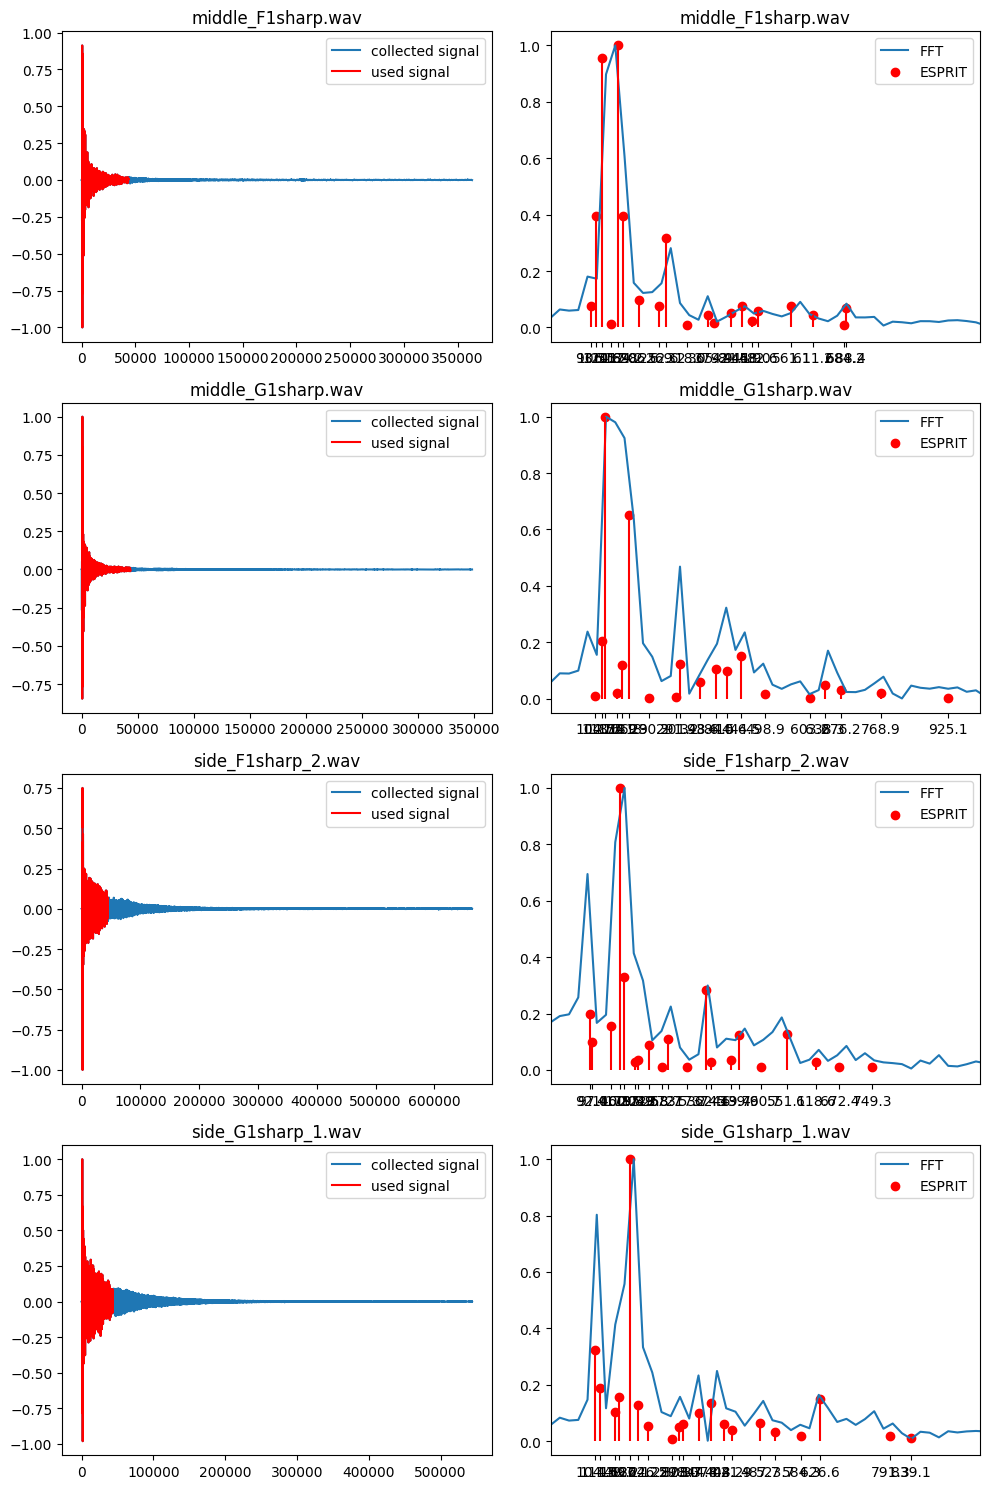

In [45]:
signals = load_signal(config)
freq_components = get_freq_plot(config, signals)

From these figures, combining the results of `FFT` and `MUSIC`, even if the frequency estimated by `MUSIC` for `middle_G1sharp.wav` is not accurate, we can still see that the frequencies are different for different knocking points. The frequency of the sound is higher when knocking at the edge of the drumhead than knocking at the center of the drumhead.

Then we plot the results of `MUSIC` and classify the timbre and knocking points in order to see the variation.

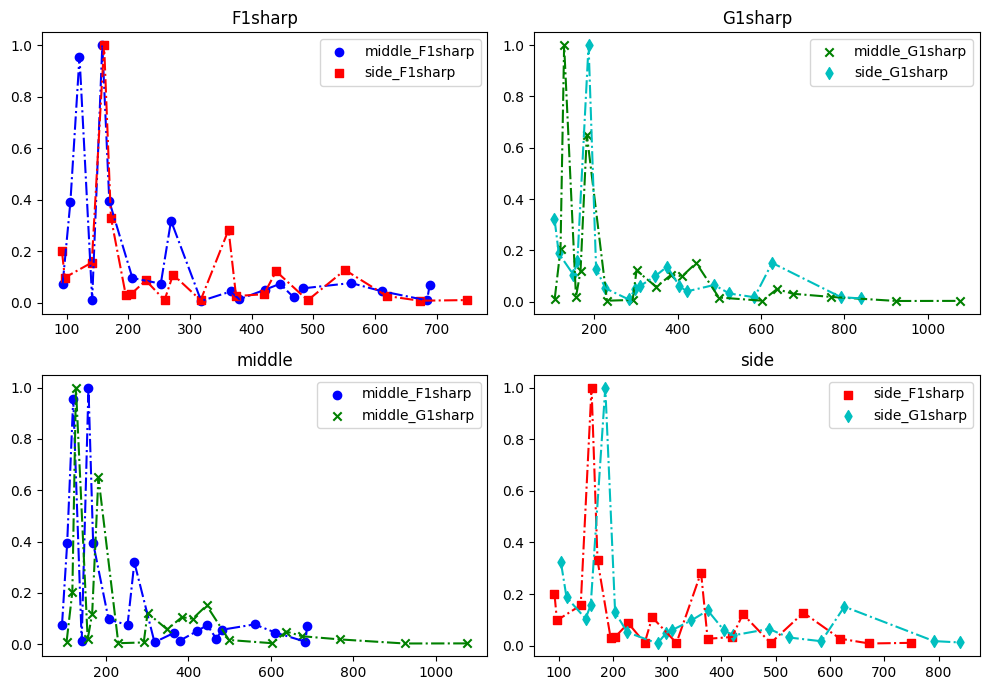

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

for idx, row in freq_components.iterrows():
    file_name = row['file_name']
    position = row['position']
    timbre = row['timbre']
    freq = row['freq']
    amp = row['amp']
    label = f'{position}_{timbre}'

    if timbre == 'F1sharp':
        ax[0, 0].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[0, 0].plot(freq, amp, linestyle='-.', color=colors[idx])
    if timbre == 'G1sharp':
        ax[0, 1].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[0, 1].plot(freq, amp, linestyle='-.', color=colors[idx])
    if position == 'middle':
        ax[1, 0].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[1, 0].plot(freq, amp, linestyle='-.', color=colors[idx])
    if position == 'side':
        ax[1, 1].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[1, 1].plot(freq, amp, linestyle='-.', color=colors[idx])

ax[0, 0].set_title('F1sharp')
ax[0 ,0].legend()
ax[0, 1].set_title('G1sharp')
ax[0 ,1].legend()
ax[1, 0].set_title('middle')
ax[1 ,0].legend()
ax[1, 1].set_title('side')
ax[1 ,1].legend()
plt.tight_layout()
plt.show()


From these figures, we can conclude that 
- higher timbre is produced the higher frequencies;
- move the knocking point from the center to the edge of the drumhead, the frequences will increase;

whcih is exactly the same as the physical phenomenon.

## Glockenspiel

In [47]:
config = {
    'data folder': 'data/glockenspiel',
    'start point threshold': 0.5, # threshold for start point detection
    'end amorti threshold': 0.01, # threshold for end point detection
    'FFT NUM': 2048,
    'ESPRIT K': 40,
    'ESPRIT n': 2048,
    'ESPRIT l': 2048 * 20,
    'xlim': [0, 10000]
}

-----F_down.wav-----
3673.570910698183
-----F_middle.wav-----
5578.98675021808
-----F_up.wav-----
3664.728010525942
-----G_down.wav-----
7512.983749623968
-----G_middle.wav-----
4882.230378120358
-----G_up.wav-----
4265.812332374855


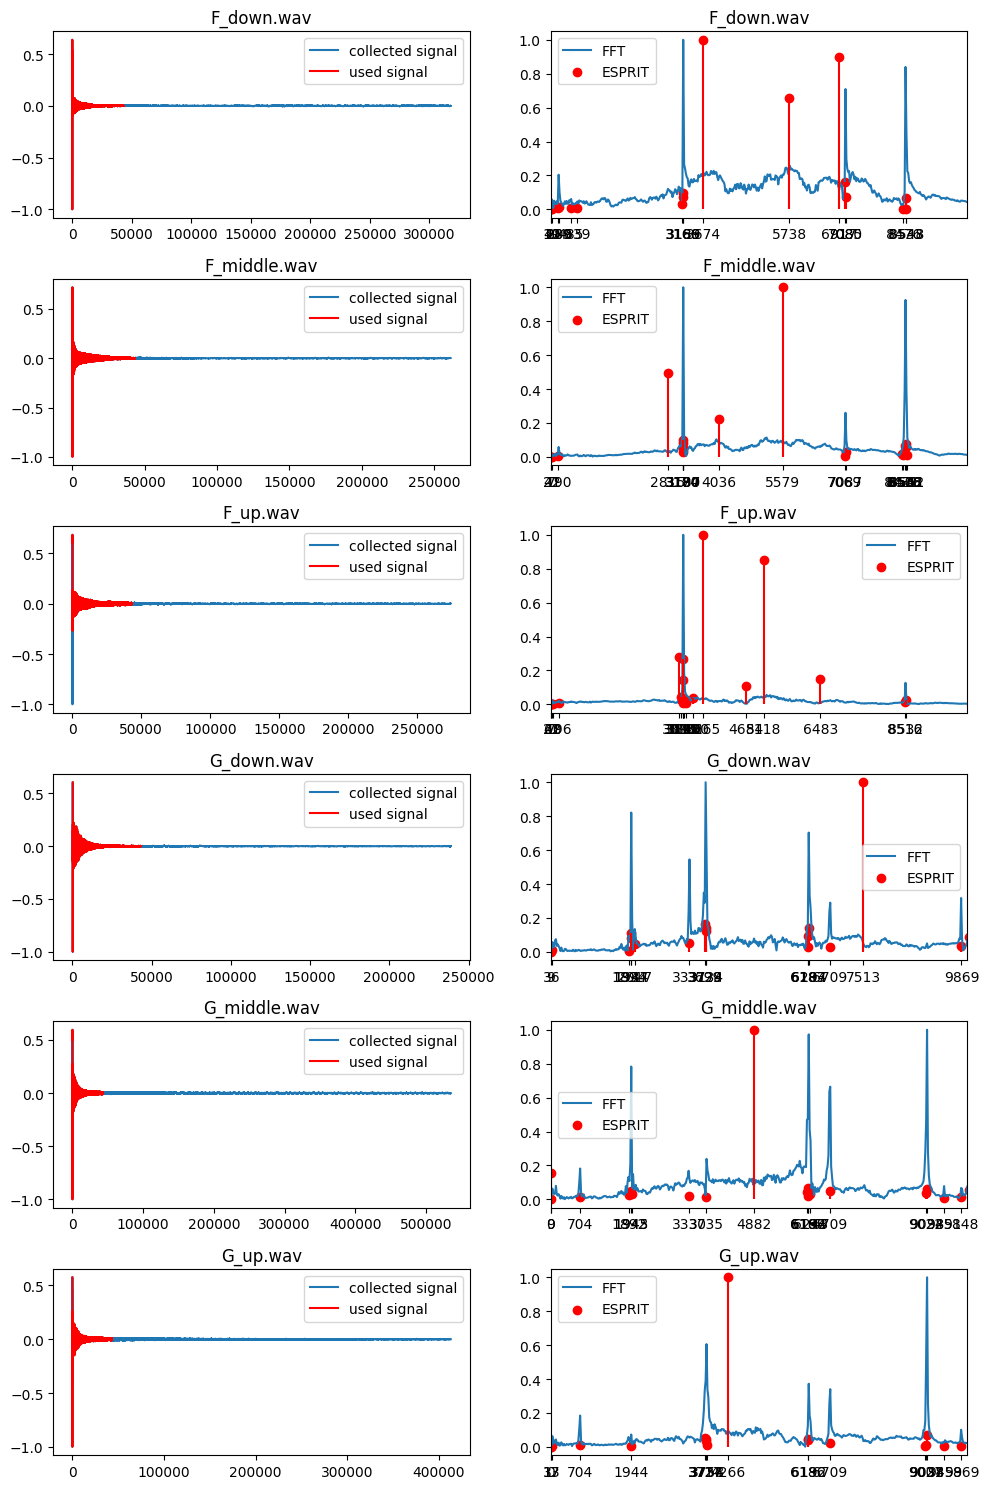

In [48]:
signals = load_signal(config)
freq_components = get_freq_plot(config, signals)

From these figures we could see that there is a large difference between the `FFT` and `MUSIC` method, that's probably because the number of points for `MUSIC` calculation is not enought, or our waves are not pure enough. So this time we only use the results of `FFT` for the data analysis, and we think the amplitude greater than 0.3 is a 'peak'.

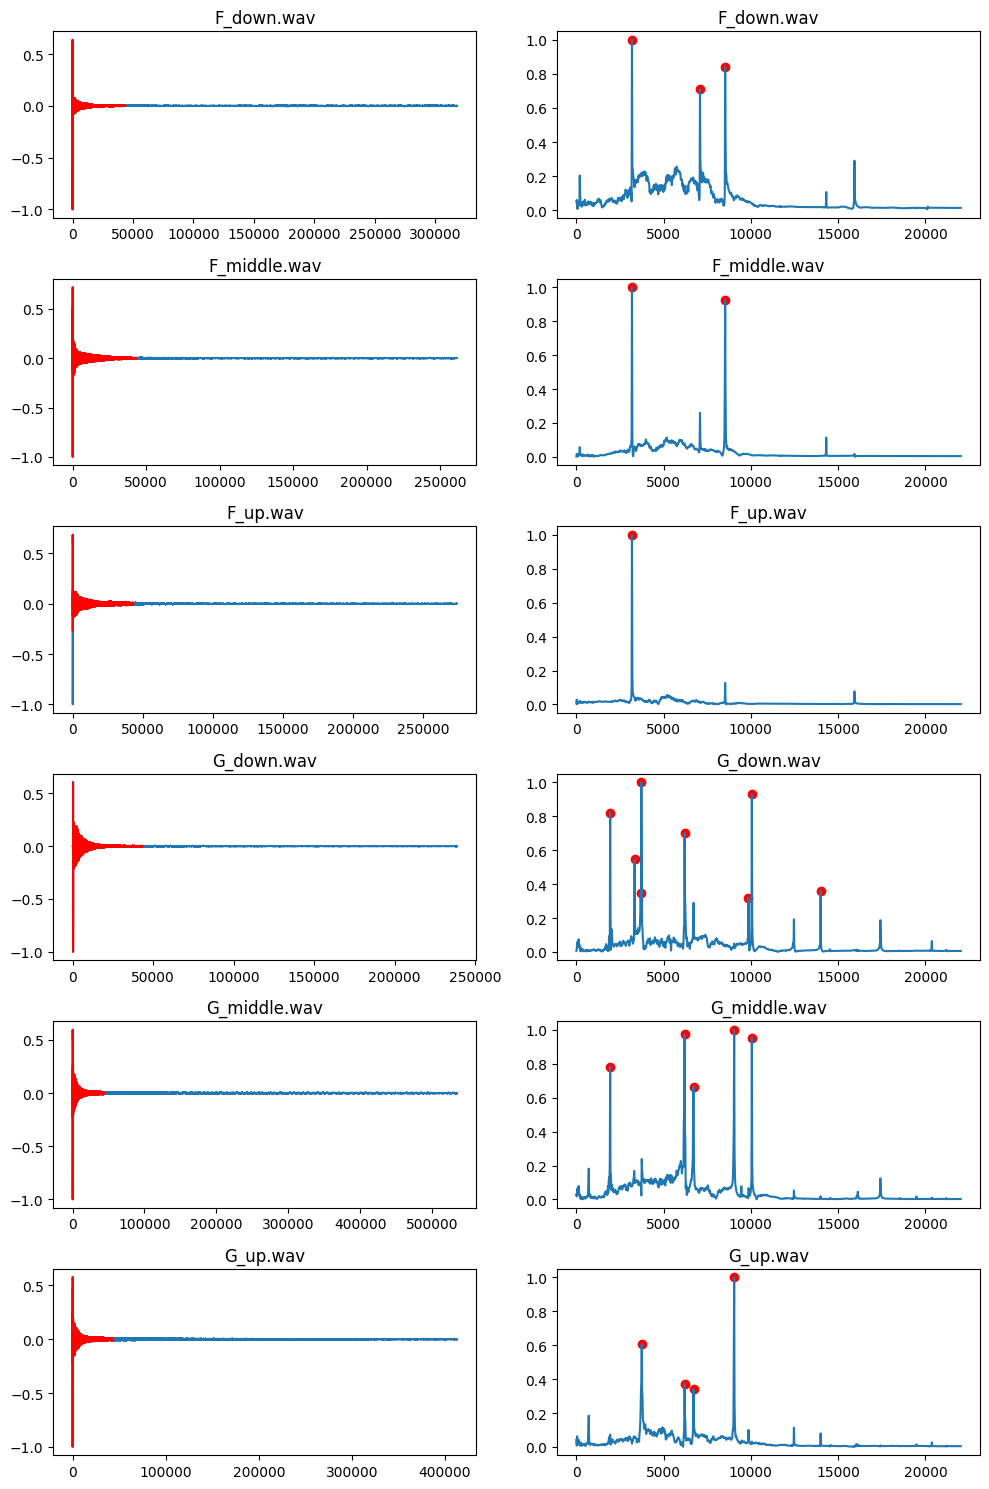

In [49]:
N_fig = len(signals)
fig, ax = plt.subplots(N_fig, 2, figsize=(10, 15))
pattern = r"(F\dsharp|G\dsharp|F|G)?_?(middle|up|down|side)?_?(F\dsharp|G\dsharp|F|G)?"
freq_components = pd.DataFrame(columns=['file_name', 'position', 'timbre', 'freq', 'amp', 'amorti_time'])

for idx, file_name, x, Fs in signals.itertuples():
    freq_components.loc[idx] = [file_name, None, None, None, None, None]
    # use regular expression to extract position and timbre from file name

    match = re.search(pattern, file_name)
    freq_components.loc[idx, 'position'] = match.group(2) if match.group(2) else "N/A"
    if match.group(1):
        freq_components.loc[idx, 'timbre'] = match.group(1)
    elif match.group(3):
        freq_components.loc[idx, 'timbre'] = match.group(3)
    else:
        freq_components.loc[idx, 'timbre'] = "N/A"

    # MUSIC method
    K = config['ESPRIT K']
    n = config['ESPRIT n']
    l = config['ESPRIT l']
    
    N = n + l - 1
    start = np.argmax(x > config['start point threshold'])
    sig = x[start: start + N]
    # get end point of amortissement
    end = np.argmax(x[start:] < config['end amorti threshold']) + start
    amorti_time = (end - start) / Fs
    freq_components.at[idx, 'amorti_time'] = amorti_time

    # FFT method
    X_fft, freqs = my_fft(sig, config['FFT NUM'], Fs)
    # normalize X_fft
    X_fft = X_fft / np.max(np.abs(X_fft))

    # find fft peaks
    peaks = find_peaks(np.abs(X_fft), height=0.3)[0]
    
    freq_components.at[idx, 'freq'] = list(freqs[peaks])
    freq_components.at[idx, 'amp'] = list(np.abs(X_fft[peaks]))

    ax[idx, 0].plot(x, label='collected signal')
    ax[idx, 0].plot(range(start, start + N), sig, label='used signal', color='red')
    ax[idx, 0].set_title(file_name)
    ax[idx, 1].plot(freqs, np.abs(X_fft), label='FFT')
    ax[idx, 1].scatter(freqs[peaks], np.abs(X_fft[peaks]), label='peaks', color='red')
    ax[idx, 1].set_title(file_name)

plt.tight_layout()
plt.show()


This time, we can see that the position of 'down' can present more modals than other two positions.

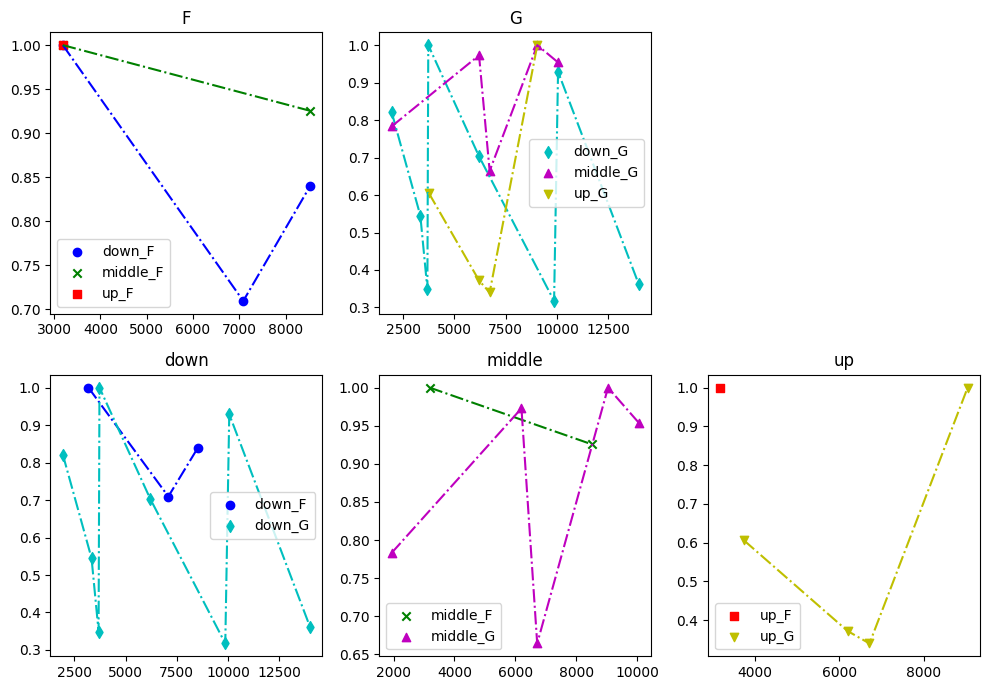

In [50]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

for idx, row in freq_components.iterrows():
    file_name = row['file_name']
    position = row['position']
    timbre = row['timbre']
    freq = row['freq']
    amp = row['amp']
    label = f'{position}_{timbre}'

    if timbre == 'F':
        ax[0, 0].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[0, 0].plot(freq, amp, linestyle='-.', color=colors[idx])
    if timbre == 'G':
        ax[0, 1].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[0, 1].plot(freq, amp, linestyle='-.', color=colors[idx])
    if position == 'down':
        ax[1, 0].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[1, 0].plot(freq, amp, linestyle='-.', color=colors[idx])
    if position == 'middle':
        ax[1, 1].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[1, 1].plot(freq, amp, linestyle='-.', color=colors[idx])
    if position == 'up':
        ax[1, 2].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[1, 2].plot(freq, amp, linestyle='-.', color=colors[idx])
fig.delaxes(ax[0, 2])
ax[0, 0].set_title('F')
ax[0 ,0].legend()
ax[0, 1].set_title('G')
ax[0 ,1].legend()
ax[1, 0].set_title('down')
ax[1 ,0].legend()
ax[1, 1].set_title('middle')
ax[1 ,1].legend()
ax[1, 2].set_title('up')
ax[1 ,2].legend()
plt.tight_layout()
plt.show()


After plot the figures of classification, we can conclude that
- the position of 'down' can present the most modals, while the position of 'up' shows the least modals;
- the higer timbre is produced the higher frequencies.

But we cannot see the variation trend of the frequencies when the knocking point moves.

## Vibraphone

-----F_down.wav-----
1328.2050664221322
-----F_middle.wav-----
175.66354598698985
-----F_up.wav-----
1876.8647588200756
-----G_down.wav-----
1478.8817063473534
-----G_middle.wav-----
1563.438889761078
-----G_up.wav-----
788.3136651165355


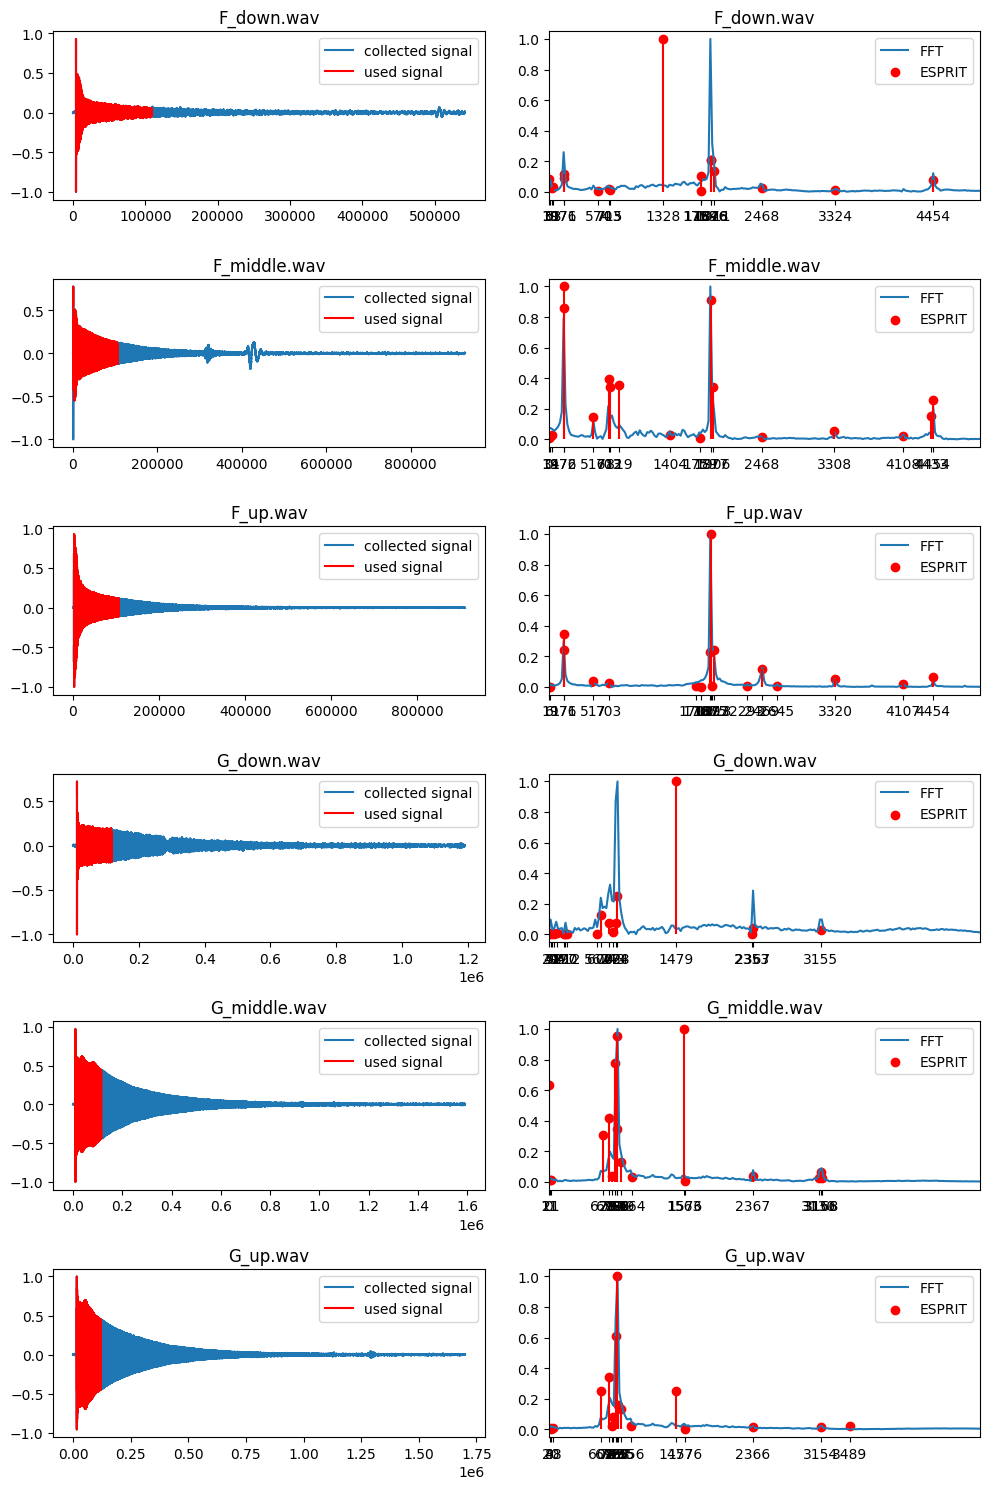

In [51]:
config = {
    'data folder': 'data/vibraphone',
    'start point threshold': 0.5, # threshold for start point detection
    'end amorti threshold': 0.01, # threshold for end point detection
    'FFT NUM': 2048,
    'ESPRIT K': 40,
    'ESPRIT n': 2048,
    'ESPRIT l': 2048 * 50,
    'xlim': [0, 5000]
}

signals = load_signal(config)
freq_components = get_freq_plot(config, signals)

We do the same thing for vibraphone, and we see that except for the `F_down.wav` and `G_down.wav`, the frequencies estimated by `MUSIC` are similar to the results of `FFT`. So we can use the results of `MUSIC` for the data analysis.

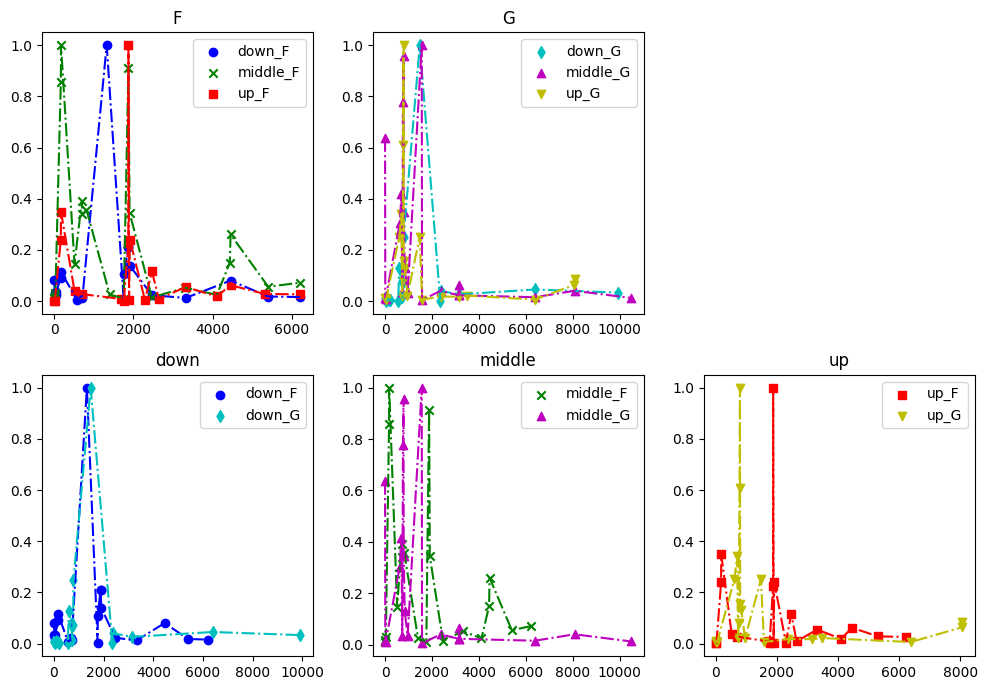

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

for idx, row in freq_components.iterrows():
    file_name = row['file_name']
    position = row['position']
    timbre = row['timbre']
    freq = row['freq']
    amp = row['amp']
    label = f'{position}_{timbre}'

    if timbre == 'F':
        ax[0, 0].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[0, 0].plot(freq, amp, linestyle='-.', color=colors[idx])
    if timbre == 'G':
        ax[0, 1].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[0, 1].plot(freq, amp, linestyle='-.', color=colors[idx])
    if position == 'down':
        ax[1, 0].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[1, 0].plot(freq, amp, linestyle='-.', color=colors[idx])
    if position == 'middle':
        ax[1, 1].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[1, 1].plot(freq, amp, linestyle='-.', color=colors[idx])
    if position == 'up':
        ax[1, 2].scatter(freq, amp, label=label, marker=marker[idx], color=colors[idx])
        ax[1, 2].plot(freq, amp, linestyle='-.', color=colors[idx])
fig.delaxes(ax[0, 2])
ax[0, 0].set_title('F')
ax[0 ,0].legend()
ax[0, 1].set_title('G')
ax[0 ,1].legend()
ax[1, 0].set_title('down')
ax[1 ,0].legend()
ax[1, 1].set_title('middle')
ax[1 ,1].legend()
ax[1, 2].set_title('up')
ax[1 ,2].legend()
plt.tight_layout()
plt.show()


From these figures, we conclude that
- modals and frequencies are different for different knocking points, and we cannot see a common trend for the different timbres;
- the position of 'middle' excites the most modals.